This notebook audits for significant changes in cluster gender annotations, to allow us to detect the significance of shifts over time.  It depends on the aligned cluster identities in `isbn-version-clusters.parquet`.


In [1]:
from functools import reduce
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

## Load Data

Define the versions we care about:


In [3]:
versions = ["pgsql", "2022-03-2.0", "2022-07", "2022-10", "2022-11-2.1", "2023-07", "current"]

Load the aligned ISBNs:


In [4]:
isbn_clusters = pd.read_parquet("isbn-version-clusters.parquet")
isbn_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43027360 entries, 0 to 43027359
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   isbn         object 
 1   isbn_id      int32  
 2   current      float64
 3   2023-07      float64
 4   2022-11-2.1  float64
 5   2022-10      float64
 6   2022-07      float64
 7   2022-03-2.0  float64
 8   pgsql        float64
dtypes: float64(7), int32(1), object(1)
memory usage: 2.7+ GB


## Different Genders

How many clusters changed gender?

To get started, we need a list of genders in order.


In [5]:
genders = [
    "ambiguous",
    "female",
    "male",
    "unknown",
    "no-author-rec",
    "no-book-author",
    "no-book",
    "absent",
]

Let's make a function to read gender info:


In [6]:
def read_gender(path, map_file=None):
    cg = pl.scan_parquet(path)
    cg = cg.select(
        [
            pl.col("cluster").cast(pl.Int32),
            pl.when(pl.col("gender") == "no-loc-author")
            .then("no-book-author")
            .when(pl.col("gender") == "no-viaf-author")
            .then("no-author-rec")
            .otherwise(pl.col("gender"))
            .cast(pl.Categorical)
            .alias("gender"),
        ]
    )
    if map_file is not None:
        map = pl.scan_parquet(map_file)
        cg = cg.join(map, on="cluster", how="left")
        cg = cg.select([pl.col("common").alias("cluster"), pl.col("gender")])
    return cg

Read each data source's gender info and map to common cluster IDs:


In [7]:
gender_cc = {
    v: read_gender(f"{v}/cluster-genders.parquet", f"{v}/cluster-map.parquet")
    for v in versions
    if v != "current"
}
gender_cc["current"] = read_gender("../book-links/cluster-genders.parquet")

/tmp/ipykernel_69125/183506089.py:6: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('no-book-author')`
  .then('no-book-author')
/tmp/ipykernel_69125/183506089.py:8: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('no-author-rec')`
  .then('no-author-rec')


Set up a sequence of frames for merging:


In [8]:
to_merge = [
    gender_cc[v].select([pl.col("cluster"), pl.col("gender").alias(v)]).unique() for v in versions
]

Merge and collect results:


In [9]:
cluster_genders = reduce(lambda df1, df2: df1.join(df2, on="cluster", how="outer"), to_merge)
cluster_genders = cluster_genders.collect()

For unclear reasons, a few versions have a null cluster. Drop that.


In [10]:
cluster_genders = cluster_genders.filter(cluster_genders["cluster"].is_not_null())

Now we will convert to Pandas and fix missing values:


In [11]:
cluster_genders = cluster_genders.to_pandas().set_index("cluster")

Now we'll unify the categories and their orders:


In [12]:
cluster_genders = cluster_genders.apply(lambda vdf: vdf.cat.set_categories(genders, ordered=True))
cluster_genders.fillna("absent", inplace=True)
cluster_genders.head()

,pgsql,2022-03-2.0,2022-07,2022-10,2022-11-2.1,2023-07,current
cluster,,,,,,,
416243397,absent,absent,absent,absent,absent,absent,no-book-author
410767599,absent,absent,absent,absent,absent,absent,no-book-author
421374693,absent,absent,absent,absent,absent,absent,no-book-author
449455849,absent,absent,absent,absent,absent,absent,no-book-author
415350734,absent,absent,absent,absent,absent,absent,no-book-author


Let's save this file for further analysis:


In [13]:
cluster_genders.to_parquet("cluster-version-genders.parquet", compression="zstd")

## PostgreSQL to Current

Now we are ready to actually compare cluster genders across categories. Let's start by comparing original data (PostgreSQL) to current:


In [14]:
ct = cluster_genders[["pgsql", "current"]].value_counts().unstack()
ct = ct.reindex(labels=genders, columns=genders)
ct

current,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
pgsql,,,,,,,,
ambiguous,98387.0,4331.0,11287.0,1856.0,996.0,2773.0,4.0,4574.0
female,16360.0,1120232.0,978.0,12941.0,9439.0,19.0,29.0,34113.0
male,28527.0,2690.0,3493131.0,18109.0,31095.0,688.0,152.0,70824.0
unknown,3004.0,102929.0,215359.0,1545706.0,19026.0,15.0,12.0,14324.0
no-author-rec,10533.0,58486.0,330352.0,226923.0,1395181.0,436.0,125.0,13658.0
no-book-author,8356.0,114884.0,219279.0,125984.0,211482.0,2457210.0,903525.0,273353.0
no-book,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
absent,121068.0,1022710.0,2439415.0,1026095.0,4539059.0,17046837.0,734647.0,65883.0


In [15]:
ctf = ct.divide(ct.sum(axis="columns"), axis="rows")


def style_row(row):
    styles = []
    for col, val in zip(row.index, row.values):
        if col == row.name:
            styles.append("font-weight: bold")
        elif val > 0.1:
            styles.append("color: red")
        else:
            styles.append(None)
    return styles


ctf.style.apply(style_row, "columns")

current,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
pgsql,,,,,,,,
ambiguous,0.792115,0.034869,0.090872,0.014943,0.008019,0.022325,0.000032,0.036825
female,0.013701,0.938131,0.000819,0.010837,0.007905,0.000016,0.000024,0.028568
male,0.007826,0.000738,0.958278,0.004968,0.008530,0.000189,0.000042,0.019429
unknown,0.001581,0.054162,0.113324,0.813369,0.010012,0.000008,0.000006,0.007537
no-author-rec,0.005174,0.028730,0.162280,0.111472,0.685359,0.000214,0.000061,0.006709
no-book-author,0.001937,0.026630,0.050829,0.029203,0.049021,0.569580,0.209437,0.063363
no-book,nan,nan,nan,nan,nan,nan,nan,nan
absent,0.004485,0.037884,0.090363,0.038010,0.168140,0.631465,0.027213,0.002440


Most of the change is coming from clusters absent in the original but present in the new.

There are also quite a few that had no book author in PGSQL, but no book in the current data - not sure what's up with that.  Let's look at more crosstabs.


In [16]:
def gender_crosstab(old, new, fractional=True):
    ct = cluster_genders[[old, new]].value_counts().unstack()
    ct = ct.reindex(labels=genders, columns=genders)

    if fractional:
        ctf = ct.divide(ct.sum(axis="columns"), axis="rows")
        return ctf
    else:
        return ct

In [17]:
def plot_gender(set):
    cluster_genders[set].value_counts().sort_index().plot.barh()
    plt.title(f"Gender Distribution in {set}")

## PostgreSQL to March 2022 (2.0 release)

This marks the change from PostgreSQL to pure-Rust.


In [18]:
ct = gender_crosstab("pgsql", "2022-03-2.0")
ct.style.apply(style_row, "columns")

2022-03-2.0,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
pgsql,,,,,,,,
ambiguous,0.977924,0.002963,0.013928,0.000636,0.000878,nan,nan,0.003671
female,0.002192,0.993942,0.000001,0.000301,0.000430,0.000003,0.000005,0.003126
male,0.000591,0.000000,0.995942,0.000528,0.000796,0.000002,0.000014,0.002127
unknown,0.000043,0.002760,0.005303,0.988899,0.001953,0.000001,0.000003,0.001038
no-author-rec,0.000104,0.007922,0.049966,0.031481,0.908594,nan,0.000008,0.001925
no-book-author,0.000002,0.000051,0.000198,0.000107,0.000053,0.649173,0.335017,0.015398
no-book,nan,nan,nan,nan,nan,nan,nan,nan
absent,0.000006,0.000049,0.000254,0.000120,0.000178,0.002007,0.000070,0.997316


This is where we change from no-book-author to no-book for a bunch of books; otherwise things are pretty consistent. This major change is likely a result of changes that count more books and book clusters - we had some inner joins in the PostgreSQL version that were questionable, and in particular we didn't really cluster solo ISBNs but now we do.  But now, if we have a solo ISBN from rating data, it gets a cluster with no book record instead of being excluded from the clustering.

Let's look at the distribution of statuses for each, starting with PostgreSQL:


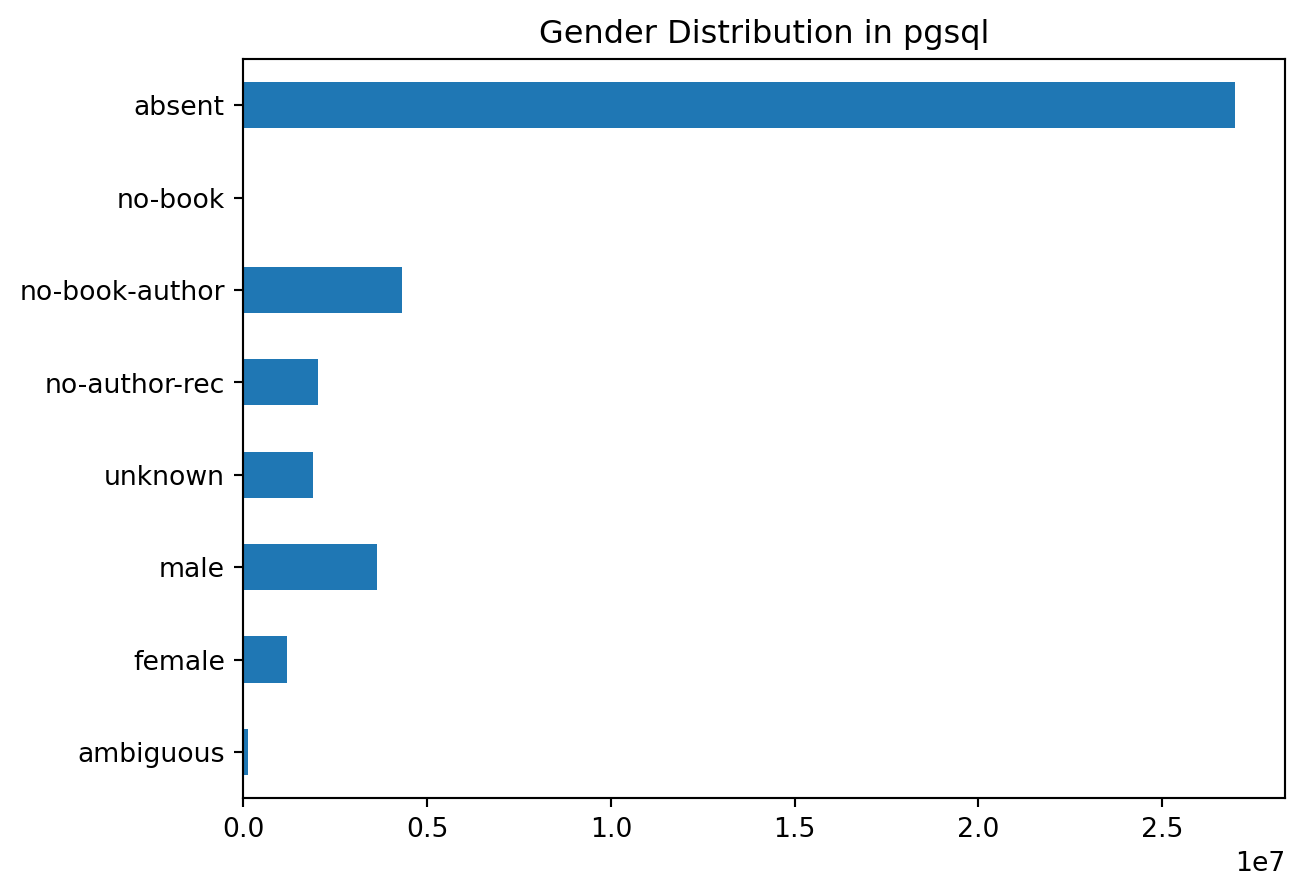

In [19]:
plot_gender("pgsql")

And the Rust version:


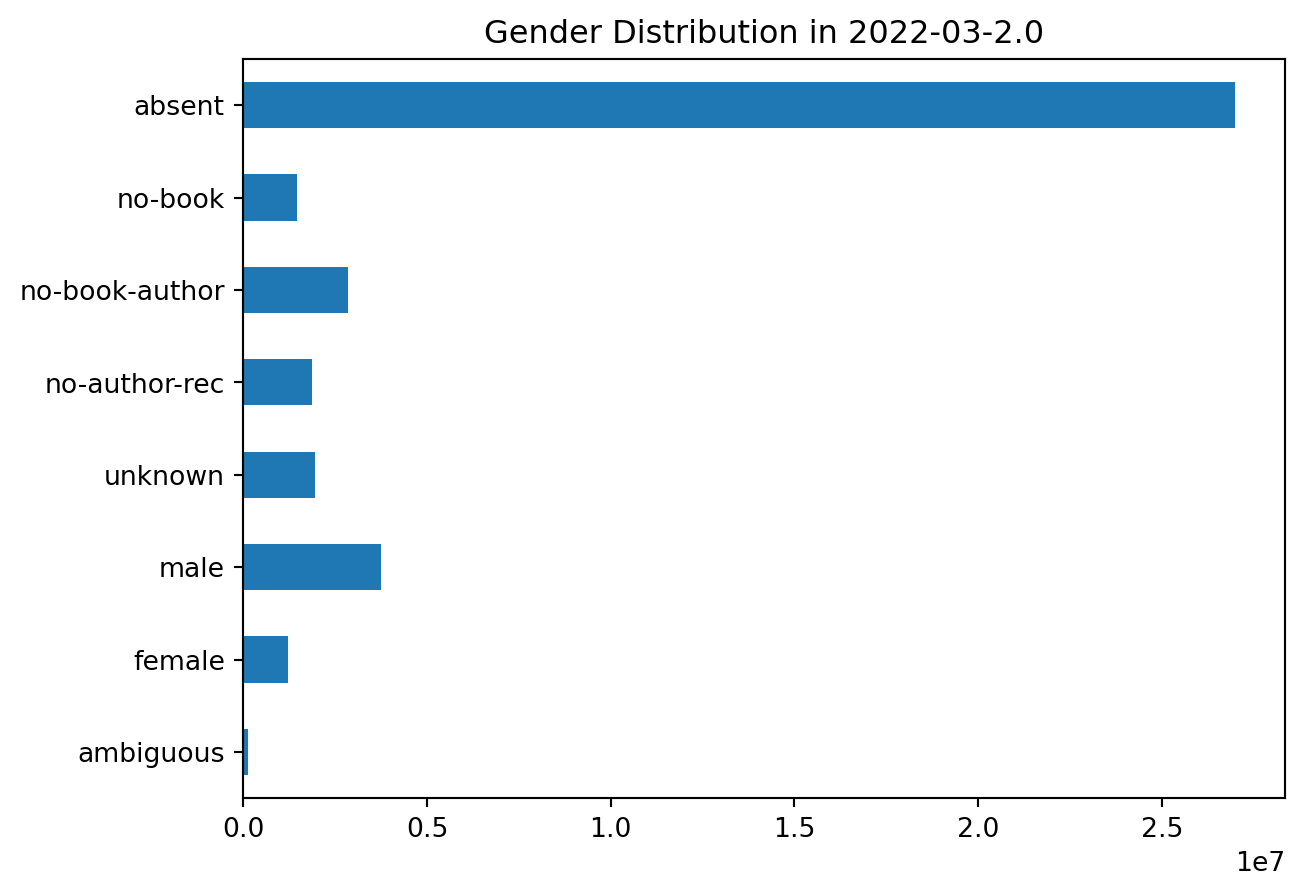

In [20]:
plot_gender("2022-03-2.0")

## March to July 2022

We updated a lot of data files and changed the name and ISBN parsing logic.


In [21]:
ct = gender_crosstab("2022-03-2.0", "2022-07")
ct.style.apply(style_row, "columns")

2022-07,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-03-2.0,,,,,,,,
ambiguous,0.836189,0.035578,0.083571,0.014798,0.004862,0.000087,0.000016,0.024900
female,0.010076,0.963180,0.000488,0.007911,0.001253,0.000002,0.000012,0.017079
male,0.006706,0.000646,0.974629,0.003702,0.001364,0.000079,0.000014,0.012859
unknown,0.001899,0.040307,0.092948,0.856037,0.003412,0.000200,nan,0.005197
no-author-rec,0.003532,0.020634,0.108700,0.101631,0.762109,0.000009,0.000037,0.003349
no-book-author,0.002058,0.030443,0.057348,0.035320,0.056237,0.809983,0.000008,0.008604
no-book,0.000156,0.002342,0.005269,0.002737,0.004768,0.000634,0.980664,0.003431
absent,0.002246,0.020150,0.043122,0.015901,0.062986,0.003484,0.000001,0.852108


Mostly fine; some more are resolved, existing resolutions are pretty consistent.


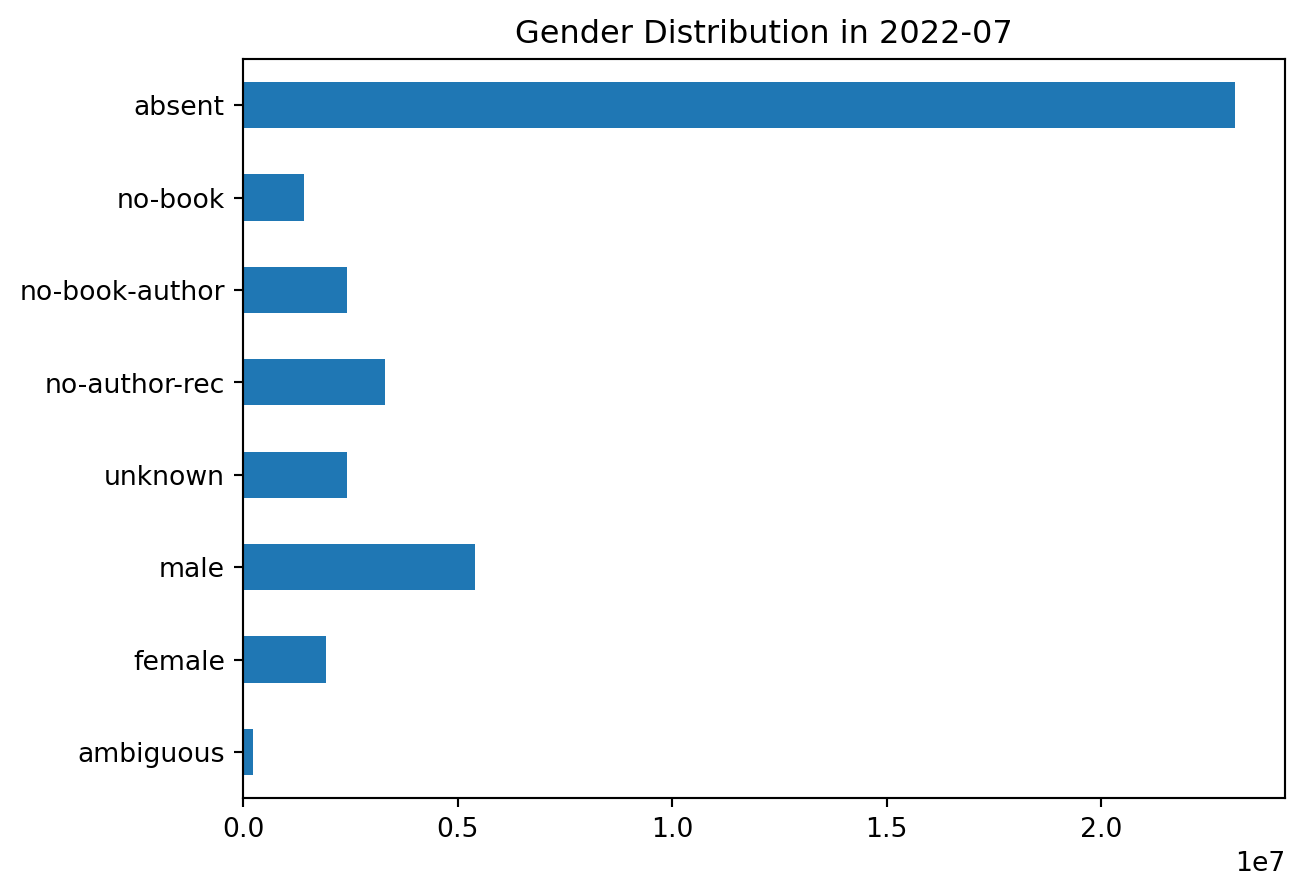

In [22]:
plot_gender("2022-07")

## July 2022 to Oct. 2022

We changed from DataFusion to Polars and made further ISBN and name parsing changes.


In [23]:
ct = gender_crosstab("2022-07", "2022-10")
ct.style.apply(style_row, "columns")

2022-10,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-07,,,,,,,,
ambiguous,0.989408,0.004969,0.003626,0.000336,0.001647,nan,nan,0.000014
female,nan,0.995091,nan,0.000361,0.004471,nan,nan,0.000078
male,0.000001,nan,0.994582,0.000431,0.004975,0.000000,nan,0.000011
unknown,nan,nan,nan,0.995469,0.004492,nan,nan,0.000040
no-author-rec,nan,0.000001,0.000003,0.000005,0.999824,0.000131,nan,0.000037
no-book-author,nan,0.000000,0.000001,0.000000,0.000000,0.996620,nan,0.003378
no-book,0.000001,0.000100,0.000029,0.000066,0.000091,0.198053,0.670216,0.131445
absent,nan,nan,nan,nan,nan,nan,nan,1.000000


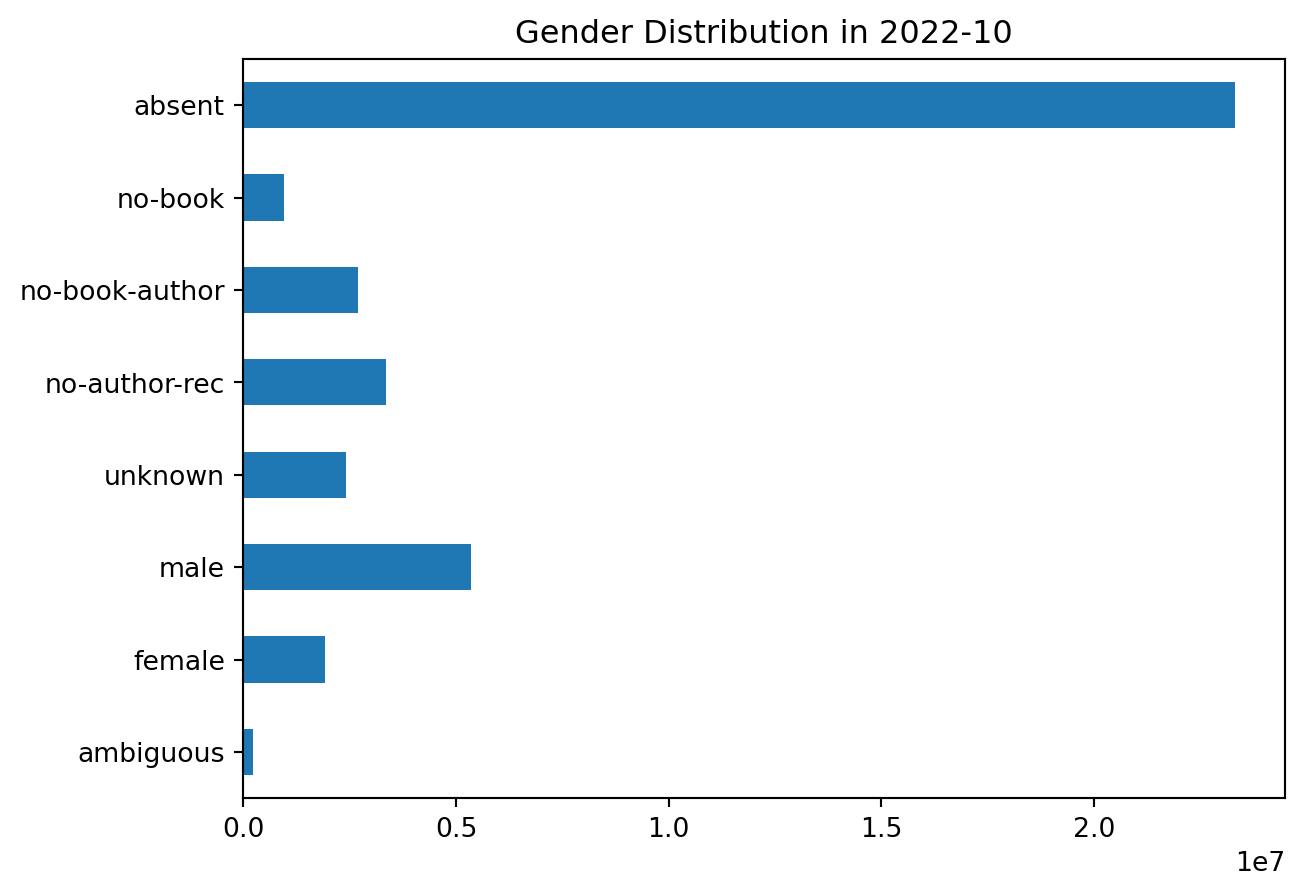

In [24]:
plot_gender("2022-10")

## Oct. 2022 to release 2.1 (Nov. 2022)

We added support for GoodReads CSV data and the Amazon 2018 rating CSV files.


In [25]:
ct = gender_crosstab("2022-10", "2022-11-2.1")
ct.style.apply(style_row, "columns")

2022-11-2.1,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-10,,,,,,,,
ambiguous,0.999995,nan,nan,nan,nan,nan,nan,0.000005
female,nan,0.999999,nan,nan,nan,nan,nan,0.000001
male,nan,nan,0.999999,nan,nan,nan,nan,0.000001
unknown,nan,nan,nan,0.999998,nan,nan,nan,0.000002
no-author-rec,nan,nan,nan,nan,0.999999,nan,nan,0.000001
no-book-author,nan,nan,nan,0.000000,nan,0.999982,nan,0.000017
no-book,nan,nan,nan,nan,nan,nan,1.000000,nan
absent,nan,0.000000,0.000000,0.000000,0.000000,0.000003,0.033872,0.966125


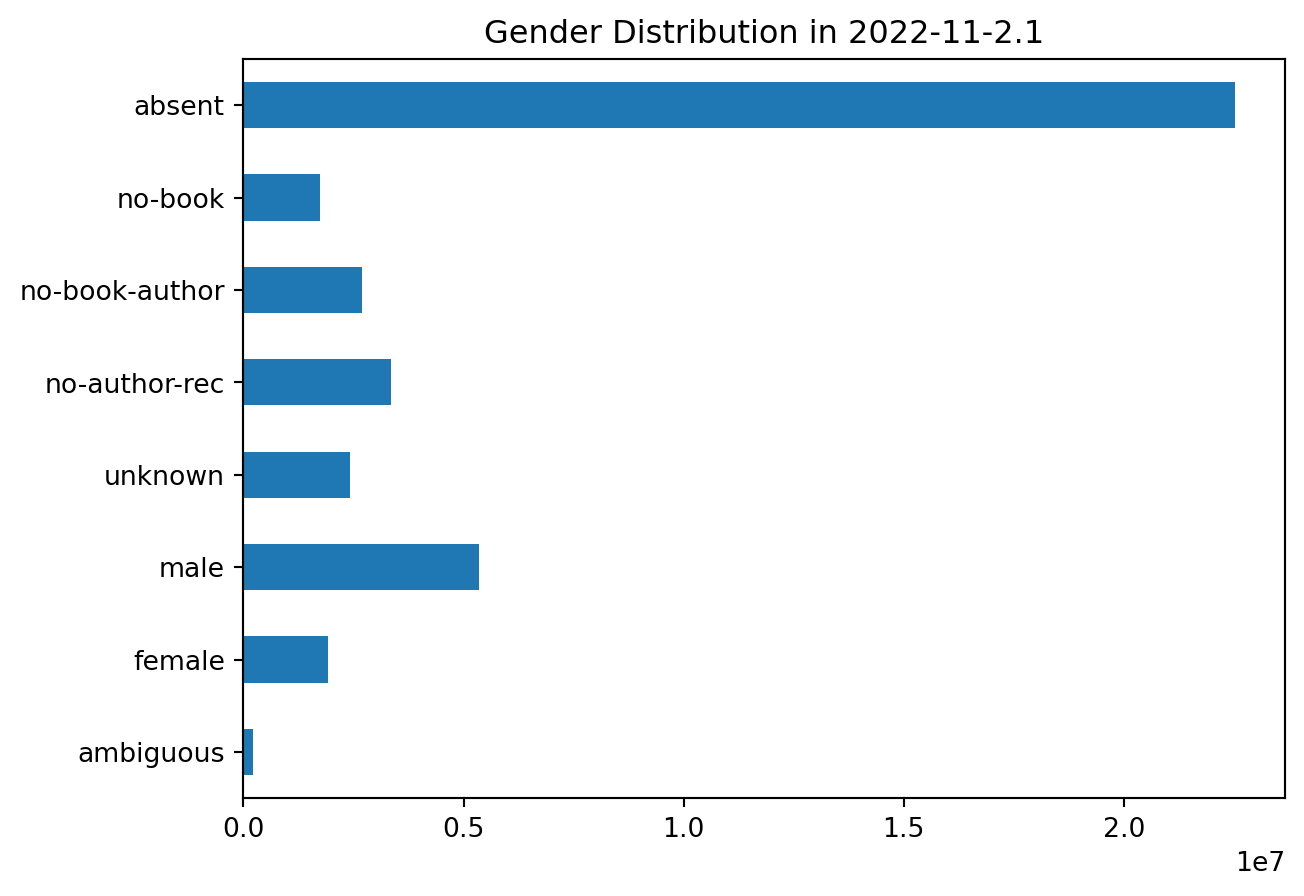

In [26]:
plot_gender("2022-11-2.1")

## Release 2.1 to Jul. 2023

We updated OpenLibrary and VIAF, and made some technical changes.


In [27]:
ct = gender_crosstab("2022-11-2.1", "2023-07")
ct.style.apply(style_row, "columns")

2023-07,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-11-2.1,,,,,,,,
ambiguous,0.879463,0.006926,0.018911,0.001573,0.000239,0.074744,0.000009,0.018136
female,0.004890,0.975552,0.000307,0.004275,0.000396,0.000482,0.000002,0.014097
male,0.002247,0.000044,0.986206,0.001428,0.000497,0.001463,0.000005,0.008110
unknown,0.000267,0.019108,0.032233,0.945152,0.001086,0.000425,0.000000,0.001728
no-author-rec,0.000278,0.002898,0.007174,0.009780,0.975848,0.000360,0.000004,0.003657
no-book-author,0.000411,0.006228,0.011051,0.004080,0.006719,0.967640,0.000001,0.003869
no-book,0.000360,0.005640,0.011799,0.007429,0.024741,0.003807,0.940827,0.005397
absent,0.003096,0.021000,0.056276,0.026941,0.127455,0.014997,0.000001,0.750233


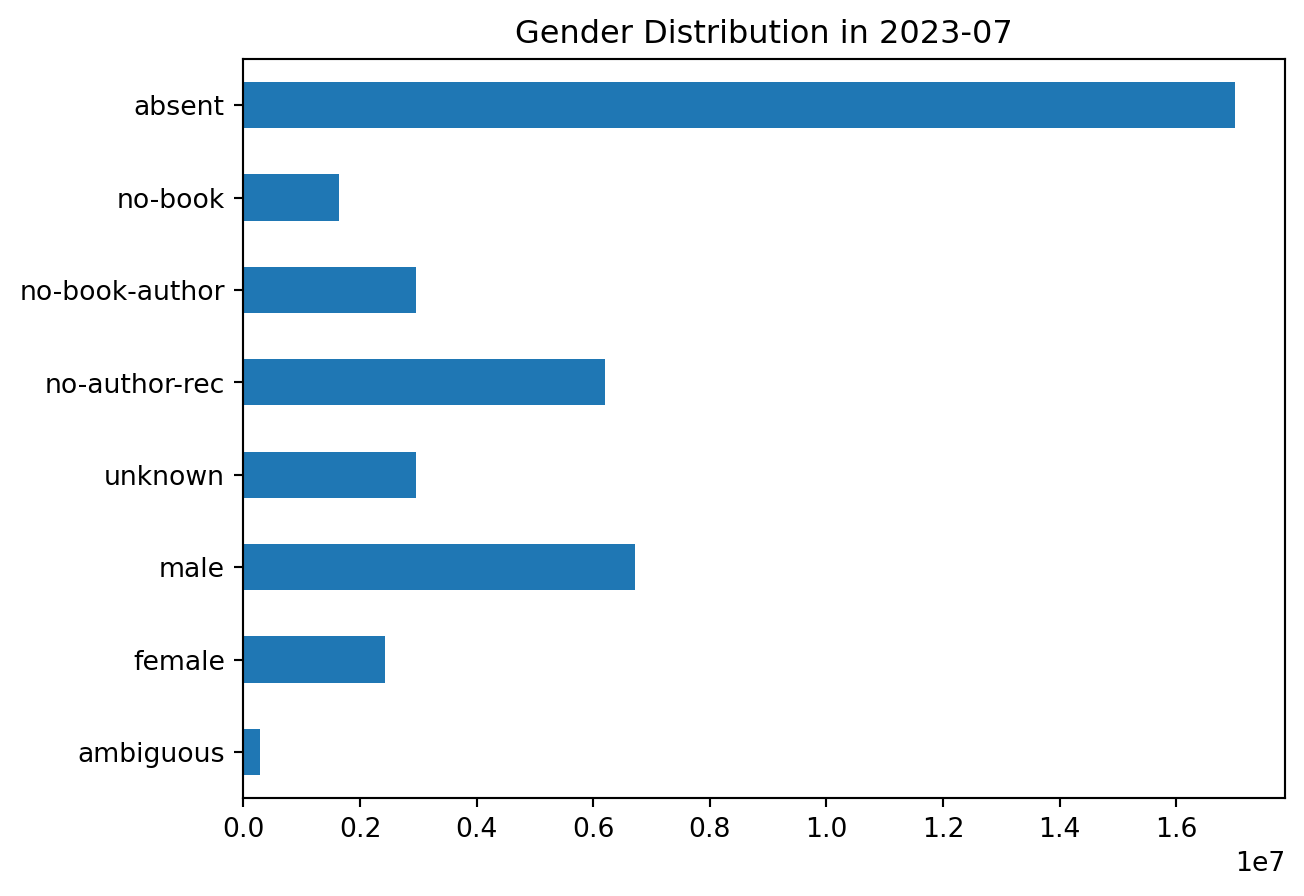

In [28]:
plot_gender("2023-07")

## Jul. 2023 to Current

Mostly technical code updates.


In [29]:
ct = gender_crosstab("2023-07", "current")
ct.style.apply(style_row, "columns")

current,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2023-07,,,,,,,,
ambiguous,1.000000,nan,nan,nan,nan,nan,nan,nan
female,nan,1.000000,nan,nan,nan,nan,nan,nan
male,nan,nan,1.000000,nan,nan,nan,nan,nan
unknown,nan,nan,nan,1.000000,nan,nan,nan,nan
no-author-rec,nan,nan,nan,nan,1.000000,nan,nan,nan
no-book-author,nan,nan,0.000000,nan,0.000000,0.999999,nan,nan
no-book,nan,nan,nan,nan,nan,nan,1.000000,nan
absent,nan,nan,nan,nan,nan,0.971987,nan,0.028013


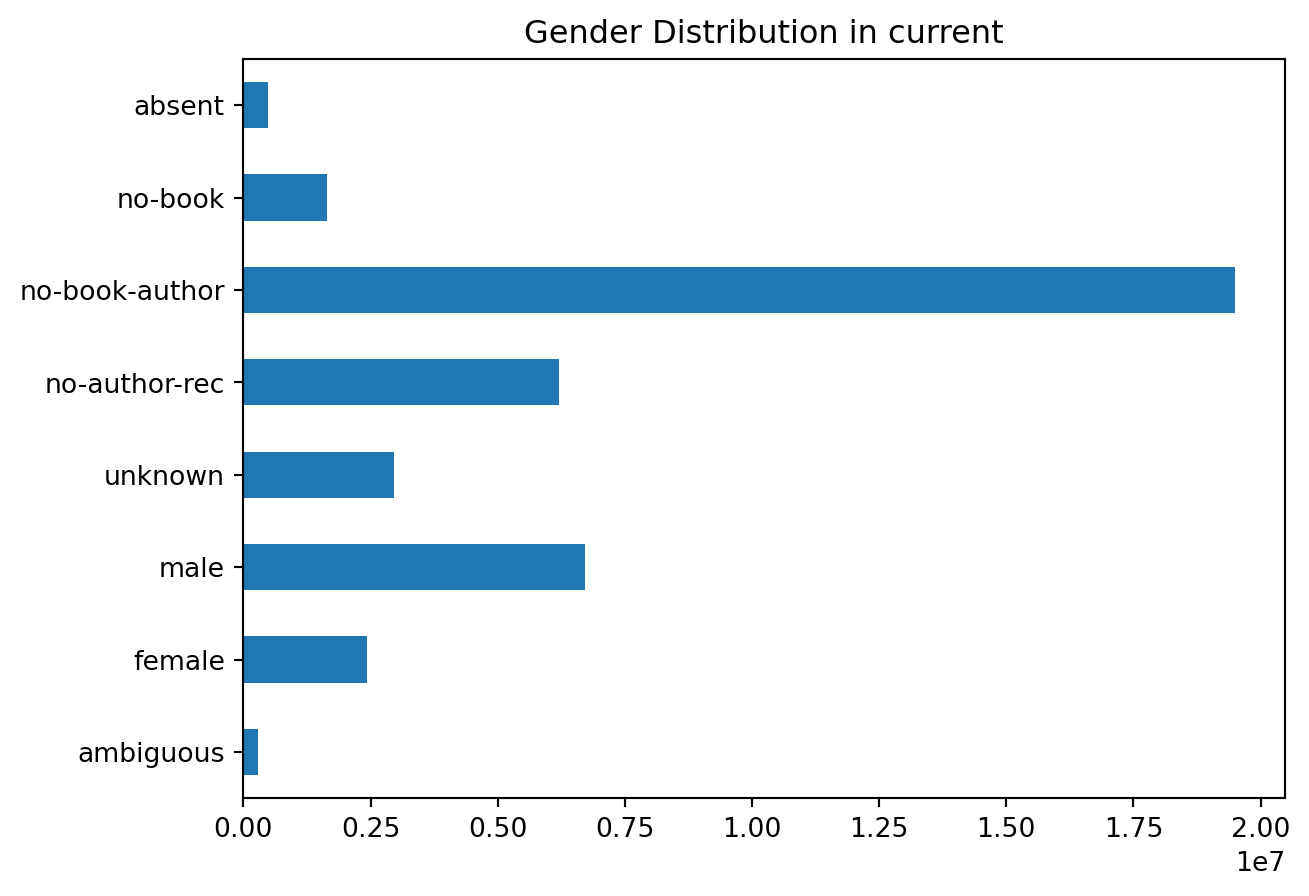

In [30]:
plot_gender("current")